# Introduction to TRGTdb API

This tutorial will show you how to programmatically access TRGT results via the TRGT API.

By the end of this introduction, you will know:
- The TRGTdb tables and their structure
- How to access the in-memory TRGTdb pandas DataFrames
- How to intersect/join across tables
- How to use some of the TRGTdb standard queries

# Loading a TRGTdb

First, we'll want to import trgt and load our database. This assumes that you've already performed a conversion on a TRGT result e.g.
```bash
trgt db create -o all_vcf.tdb son.vcf.gz mother.vcf.gz father.vcf.gz
```

In [1]:
import trgt

data = trgt.load_tdb("../test_files/databases/all_vcf.tdb")

This returns a dictionary with structure:

| Key | Details |
| --- | ------- |
| locus | Tandem repeat loci inside the database |
| allele | Alleles observed on each locus |
| sample | Tables of each sample's observed alleles |

## The Locus Table
Looking at our `locus` table first, we see that it holds a Pandas DataFrame of the LocusID and genomic position TRGT analyzed

In [2]:
data["locus"].head()

,LocusID,chrom,start,end
0,3,chr1,16682,16774
1,9,chr1,19275,19473
2,4,chr1,20798,20893
3,2,chr1,29714,29822
4,0,chr1,30824,30989


In [3]:
print(f"Total number of loci: {len(data['locus'])}")

Total number of loci: 77213


Because the table in-memory is just a DataFrame, we can of course do analyis on it. For example, if we wanted to know how many base-pairs are spanned by tandem repeat loci:

In [4]:
loci = data["locus"] # Make a direct variable to the table so we don't have to type `data["locus"]` every time
locus_span = loci['end'] - loci['start']
total_locus_span = locus_span.sum()
print(f"Total bases: {total_locus_span}")

Total bases: 9482540


Similarly, we can use the `locus_span` to check the distribution lengths. We'll use seaborn to plot a histogram.

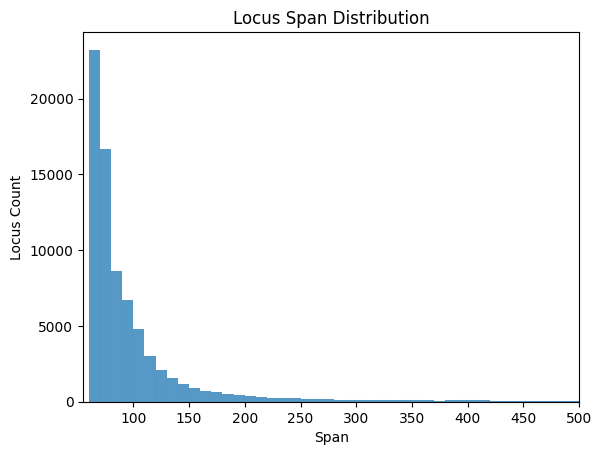

,count,mean,std,min,25%,50%,75%,max
0,77213.0,122.810149,382.31894,60.0,67.0,78.0,104.0,48491.0


In [5]:
import seaborn as sb
import matplotlib.pyplot as plt

p = sb.histplot(locus_span, binwidth=10)
p.set(title="Locus Span Distribution", 
      xlabel="Span", 
      ylabel="Locus Count",
      xlim=(55,500)) # Zoom in to make the plot more attractive
plt.show()

locus_span.describe().to_frame().T

## The Allele table

Every locus can have multiple observed alleles. There's always the reference allele, and then some number of alternate alleles.

In [6]:
allele = data["allele"] # Again, just making a convience variable
allele.head()

,LocusID,allele_number,allele_length,sequence
0,0,0,165,TTATAGATCTGGTAAGAAAAGAGAGCATTGTCTCTGTGTCTCCCTC...
1,0,1,139,TTATAGATCTGGTAAGAAAAGAGAGCATTGTCTCTCTGTCTCCCTC...
2,0,2,163,TTATAGATCTGGTAAGAAAAGAGAGCATTGTCTCTGTGTCTCCCTC...
3,0,3,167,TTATAGATCTGGTAAGAAAAGAGAGCATTGTCTCTGTGTCTCCCTC...
4,1,0,70,GTGTATATGCTCCACGATGCCTGTGAATATACACACACACCACATC...


There are four columns in the allele table.

- LocusID : The primary key that ties the allele to its locus
- allele_number : The identifier for this allele at the locus. Note that `allele_number == 0` is always the reference allele
- allele_length : The length of the allele
- sequence : The sequence of the allele

We can again use pandas to get some basic summaries of our our alleles.

In [7]:
from IPython.display import display # Helps display pretty Tables

print("What is the distribution of allele lengths?")
display(allele['allele_length'].describe().to_frame())

print("\n\nHow many alleles are there per-locus?")
alleles_per_locus = allele['LocusID'].value_counts()
display(alleles_per_locus.describe().to_frame())

What is the distribution of allele lengths?


,allele_length
count,213156.000000
mean,143.178527
std,398.290971
min,9.000000
25%,68.000000
50%,79.000000
75%,108.000000
max,48491.000000




How many alleles are there per-locus?


,LocusID
count,77213.000000
mean,2.760623
std,1.185621
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,7.000000


We can use the LocusID to join our alleles to the locus table to create an expanded view of the data

In [8]:
view = allele.join(loci, on="LocusID", rsuffix='_')
view[["chrom", "start", "end", "allele_length"]]

,chrom,start,end,allele_length
0,chr1,16682,16774,165
1,chr1,16682,16774,139
2,chr1,16682,16774,163
3,chr1,16682,16774,167
4,chr1,19275,19473,70
...,...,...,...,...
213151,chr1,248937524,248938705,76
213152,chr1,248937524,248938705,8588
213153,chr1,248937524,248938705,8652
213154,chr1,248937524,248938705,5149


What if we wanted to get the coordinates of loci with at least four alleles? We can use our `alleles_per_locus` created above to subset to loci with at least four alleles and then we'd again use the LocusID.

In [9]:
m_subset = alleles_per_locus[alleles_per_locus >= 4].index # This Series' index is LocusID
view = loci[loci["LocusID"].isin(m_subset)]
print(f"Of the {len(loci)} Loci, {len(view)} have >= 4 alleles")
view.head()

Of the 77213 Loci, 18218 have >= 4 alleles


,LocusID,chrom,start,end
4,0,chr1,30824,30989
11,12,chr1,54682,54847
13,27,chr1,66127,66662
24,23,chr1,98969,99141
26,25,chr1,104130,104226


Doing this `.isin()` operation isn't our only option. We can leverage pandas DataFrame indexing by setting the locus table's index to LocusID and then repeat the query.

In [10]:
loci = loci.set_index("LocusID")
view = loci.loc[m_subset]
print(f"Of the {len(loci)} Loci, {len(view)} have >= 4 alleles")
view.head()

Of the 77213 Loci, 18218 have >= 4 alleles


,chrom,start,end
72379,chr1,236405695,236405952
41145,chr1,119251051,119251288
69246,chr1,224011660,224016583
23149,chr1,57421862,57421951
2075,chr1,5977818,5977961


## The Sample tables

Every sample contained in a TRGTdb has its own table. Therefore, the `data` dictionary's key "sample" holds a value of a sub-dictionary with keys of the sample's name and a value with the DataFrame. We can see that in this example data, we have three samples:

In [11]:
print(data['sample'].keys())
# And lets go ahead and look at the first sample's table
data['sample']['son'].head()

dict_keys(['son', 'father', 'mother'])


,LocusID,allele_number,spanning_reads,length_range_lower,length_range_upper,average_methylation
0,0,1,15,135,167,NaN
1,1,1,18,69,70,NaN
2,2,1,18,106,109,NaN
3,3,0,29,90,95,NaN
4,4,0,65,94,95,NaN


The columns of a sample table are:
    
- LocusID : The key that ties to the locus and allele table
- allele_number : The key that ties to the allele table
- spanning_reads : How many reads span the sample's observed allele
- length_range_lower : Lower limit of the sample's observed allele length
- length_range_upper : Upper limit of the sample's observed allele length
- average_methylation : Sample's observed allele's mean methylation level

We can check how many alleles are observed per-sample:

In [12]:
for sample_name, table in data['sample'].items():
    print(f"{sample_name} has {len(table)} alleles")

son has 154228 alleles
father has 154134 alleles
mother has 154186 alleles


Or we can check how many alleles with at least 10 spanning reads are observed per sample

In [13]:
MINSPANCNT = 10
for sample_name, table in data['sample'].items():
    min_ten = table[table["spanning_reads"] >= MINSPANCNT]
    print(f"{sample_name} has {len(min_ten)} alleles with >= {MINSPANCNT} spanning reads")

son has 140473 alleles with >= 10 spanning reads
father has 125313 alleles with >= 10 spanning reads
mother has 131477 alleles with >= 10 spanning reads


Another complexity to the sample tables (besides that there is one per-sample) is that we use the sample tables' LocusID and allele_number as keys. Therefore, when joining a sample table to the locus or allele tables, we need to consider which columns to use as keys.

The simplier join is between locus and a sample since it only needs the LocusID column and above we already set the locus table's index to LocusID. For this example we'll look up the coordinates of loci over which our 'son' sample has a non-reference (i.e. alternate) allele.

In [14]:
son = data['sample']['son']

son_nonref_alleles = son[son["allele_number"] != 0]

# We get the unique LocusID because the sample may have two different alternate alleles
# such that a single LocusID would be in two rows e.g. (LocusID 1234 could have allele_number 1 and 2)
son_nonref_loci = son_nonref_alleles["LocusID"].unique() 

print(f"son has {len(son_nonref_loci)} loci with non-REF alleles")
view = loci.loc[son_nonref_loci]
view.head()

son has 58555 loci with non-REF alleles


,chrom,start,end
LocusID,,,
0,chr1,30824,30989
1,chr1,31777,31847
2,chr1,29714,29822
5,chr1,44805,44906
6,chr1,35458,35537


The slightly more complex intersection is between the allele and sample tables. But after setting a MultiIndex on the allele table, the intersection is easy enough.

In [15]:
allele = allele.set_index(["LocusID", "allele_number"])

# Turning this into a list so we can use it to access the new alelle MultiIndex
to_lookup = son_nonref_alleles[["LocusID", "allele_number"]].values.tolist()
son_sample = allele.loc[to_lookup].sample(5, random_state=42) # And we'll look at 5 random alleles.
son_sample

,,allele_length,sequence
LocusID,allele_number,,
9654,1,76,TTTAACGACCTGATGTGACTAGCTCTTTTTTTTTTTTTTTTTTTTT...
19007,1,62,GAGCCACCGTGCCTGGCCTGATAATTTTTTTTTTTTTAAAGTACTT...
26033,1,139,AGTTCTCCAGAGAGACAGAACTGAACAAATTGTGTGTGTGTGTGTG...
56040,2,98,GATTAGAACAATTGTGGCATAGTGGGGAAAACACACACACACACAC...
71960,2,76,GGATTACAGGCATGAGCCACCGTGCTCTTTTTTTTTTTTTCTTTTT...


We could perform this intersection easier by simply merging the tables, though this comes at a cost to memory usage since we're creating a new, larger table

In [16]:
import pandas as pd
merged = pd.merge(allele.reset_index(), # unset the index we just made
                  son_nonref_alleles, # then merge with this
                  on=['LocusID','allele_number']) # on the two key columns
merged.head()

,LocusID,allele_number,allele_length,sequence,spanning_reads,length_range_lower,length_range_upper,average_methylation
0,0,1,139,TTATAGATCTGGTAAGAAAAGAGAGCATTGTCTCTCTGTCTCCCTC...,15,135,167,NaN
1,0,1,139,TTATAGATCTGGTAAGAAAAGAGAGCATTGTCTCTCTGTCTCCCTC...,15,139,139,NaN
2,1,1,70,GTGTATATGCTCCACGATGCCTGTGAATATACAAACACACCACATC...,18,69,70,NaN
3,1,2,71,AGTGTATATGCTCCACGATGCCTGTGAATATACAAACACACCACAT...,6,71,73,NaN
4,2,1,108,GCCCTCGCCCTGGGTGCGCCCCGGGGCAGGACCCCCAGCCCAGGTC...,18,106,109,NaN


Inside our `son_sample` we have five non-REF alleles observed in the son. Let's check to see if those alleles are found in the mother and father samples.

In [17]:
mom = data['sample']['mother'].set_index(["LocusID", "allele_number"])
display(mom[mom.index.isin(son_sample.index)])

pop = data['sample']['father'].set_index(["LocusID", "allele_number"])
display(pop[pop.index.isin(son_sample.index)])

,,spanning_reads,length_range_lower,length_range_upper,average_methylation
LocusID,allele_number,,,,
19007,1,14,61,62,NaN
56040,2,15,98,100,NaN


,,spanning_reads,length_range_lower,length_range_upper,average_methylation
LocusID,allele_number,,,,
9654,1,18,75,76,NaN
19007,1,24,61,62,NaN
26033,1,27,137,141,NaN
56040,2,15,96,100,NaN


For these 5 non-reference alleles in the son, we can see that two of them from loci 19007 and 56040 are also present in both the parents. Two of them (LocusIDs 9654 and 26033) are found in only the father. And one of them (71960) isn't shared with either parent.

Let's compare all of the alleles across these loci across all three samples:

In [18]:
son = son.set_index(["LocusID", "allele_number"])

In [26]:
for locus, allele_number in son_sample.index:
    print(f"==== Examining Locus ====\n{loci.loc[locus]}")
    print("All Alleles at the Locus:")
    display(allele.loc[locus])
    print("Son")
    display(son.loc[locus])
    print("Mother")
    display(mom.loc[locus])
    print("Father")
    display(pop.loc[locus])

==== Examining Locus ====
chrom        chr1
start    23119226
end      23119301
Name: 9654, dtype: object
All Alleles at the Locus:


,allele_length,sequence
allele_number,,
0,75,TTTAACGACCTGATGTGACTAGCTCTTTTTTTTTTTTTTTTTTTTT...
1,76,TTTAACGACCTGATGTGACTAGCTCTTTTTTTTTTTTTTTTTTTTT...
2,77,TTTAACGACCTGATGTGACTAGCTCTTTTTTTTTTTTTTTTTTTTT...


Son


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
1,14,75,76,NaN
2,27,77,80,NaN


Mother


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
0,18,73,76,NaN
2,15,77,78,NaN


Father


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
1,18,75,76,NaN
2,6,77,79,NaN


==== Examining Locus ====
chrom        chr1
start    45032768
end      45032831
Name: 19007, dtype: object
All Alleles at the Locus:


,allele_length,sequence
allele_number,,
0,63,GAGCCACCGTGCCTGGCCTGATAATTTTTTTTTTTTTTAAAGTACT...
1,62,GAGCCACCGTGCCTGGCCTGATAATTTTTTTTTTTTTAAAGTACTT...
2,63,GAGCCACCGTGCCTGGCCTGATAATTTTTTTTTTTTTAAAGTACTT...


Son


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
1,27,59,62,NaN
2,7,63,63,NaN


Mother


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
0,19,63,65,NaN
1,14,61,62,NaN


Father


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
0,13,63,70,NaN
1,24,61,62,NaN


==== Examining Locus ====
chrom        chr1
start    66545598
end      66545725
Name: 26033, dtype: object
All Alleles at the Locus:


,allele_length,sequence
allele_number,,
0,127,AGTTCTCCAGAGAGACAGAACTGAACAAATTGTGTGTGTGTGTGTG...
1,139,AGTTCTCCAGAGAGACAGAACTGAACAAATTGTGTGTGTGTGTGTG...
2,129,AGTTCTCCAGAGAGACAGAACTGAACAAATTGTGTGTGTGTGTGTG...
3,129,AGTTCTCCAGAGAGACAGAACTGAACAAATTGTGTGTGTGTGTGTG...


Son


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
0,23,125,129,NaN
1,22,137,140,NaN


Mother


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
0,30,125,128,NaN
2,28,129,132,NaN


Father


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
3,18,127,130,NaN
1,27,137,141,NaN


==== Examining Locus ====
chrom         chr1
start    187415702
end      187415810
Name: 56040, dtype: object
All Alleles at the Locus:


,allele_length,sequence
allele_number,,
0,108,GATTAGAACAATTGTGGCATAGTGGGGAAAACACACACACACACAC...
1,96,GATTAGAACAATTGTGGCATAGTGGGGAAAACACACACACACACAC...
2,98,GATTAGAACAATTGTGGCATAGTGGGGAAAACACACACACACACAC...
3,104,GATTAGAACAATTGTGGCATAGTGGGGAAAACACACACACACACAC...


Son


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
1,22,95,97,NaN
2,18,98,100,NaN


Mother


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
1,22,93,97,NaN
2,15,98,100,NaN


Father


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
2,15,96,100,NaN
3,22,102,106,NaN


==== Examining Locus ====
chrom         chr1
start    235572468
end      235572544
Name: 71960, dtype: object
All Alleles at the Locus:


,allele_length,sequence
allele_number,,
0,76,GGATTACAGGCATGAGCCACCGTGCTCTTTTTTTTTTTTCTTTTTT...
1,75,GGATTACAGGCATGAGCCACCGTGCTCTTTTTTTTTTTTCTTTTTT...
2,76,GGATTACAGGCATGAGCCACCGTGCTCTTTTTTTTTTTTTCTTTTT...


Son


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
1,30,74,75,NaN
2,10,76,77,NaN


Mother


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
0,16,76,77,NaN
1,18,74,75,NaN


Father


,spanning_reads,length_range_lower,length_range_upper,average_methylation
allele_number,,,,
0,6,76,77,NaN
1,21,73,75,NaN


We'll leave it as an exercise for the reader to determine the mendelian consistency of the variants in these 5 loci. Also, you may find combining the tables presented above into a single report to be excellent practice for creating your own TRGTdb queries.

# TRGTdb queries

The tutorial up to this point has really been more of a primer on how to use Pandas. However, it's possible to perform some queries on a TRGTdb without too much Pandas knowledge. Below we'll show you the results and descriptions of some of the basic TRGTdb queries.

In [20]:
# This is equivalent to the command line `trgt db query allele_cnts data.tdb`
print(trgt.allele_count.__doc__)
trgt.allele_count(data)


    Allele counts and frequency
    


,chrom,start,end,allele_number,AC,AF
LocusID,,,,,,
0,chr1,30824,30989,1,4,0.666667
0,chr1,30824,30989,2,1,0.166667
0,chr1,30824,30989,3,1,0.166667
1,chr1,31777,31847,1,3,0.500000
1,chr1,31777,31847,0,2,0.333333
...,...,...,...,...,...,...
77211,chr1,248752443,248754675,4,1,0.166667
77212,chr1,248404165,248404241,1,2,0.333333
77212,chr1,248404165,248404241,2,2,0.333333


In [21]:
# This is equivalent to the command line `trgt db query allele_cnts_bylen data.tdb`
print(trgt.allele_count_length.__doc__)
trgt.allele_count_length(data)


    Allele counts and frequency by allele length
    


,chrom,start,end,is_ref,allele_length,AC,AF
LocusID,,,,,,,
0,chr1,30824,30989,False,139,4,0.666667
0,chr1,30824,30989,False,163,1,0.166667
0,chr1,30824,30989,False,167,1,0.166667
1,chr1,31777,31847,True,70,5,0.833333
1,chr1,31777,31847,False,71,1,0.166667
...,...,...,...,...,...,...,...
77211,chr1,248752443,248754675,False,2227,1,0.166667
77212,chr1,248404165,248404241,False,8588,2,0.333333
77212,chr1,248404165,248404241,False,8652,2,0.333333


In [22]:
# This is equivalent to the command line `trgt db query monref data.tdb`
print(trgt.monref.__doc__)
trgt.monref(data)


    Monozygotic reference sites per-sample and overall
    


,sample,loci,mon_ref,pct
0,son,77114,18559,0.240670
1,father,77067,18344,0.238027
2,mother,77093,17574,0.227958
3,all,77213,11040,0.142981


In [23]:
# This is equivalent to the command line `trgt db query methyl data.tdb`
print(trgt.methyl.__doc__)
trgt.methyl(data)


    Allele length, methylation, and CpG stats (PMID:3656447)
    


,LocusID,allele_number,allele_length,average_methylation,CpG_obs,CpG_exp,CpG_density,GC_pct
0,0,1,139,NaN,1,5.381295,0.014388,0.438849
1,0,1,139,NaN,1,5.381295,0.014388,0.438849
2,1,1,70,NaN,1,3.257143,0.028571,0.442857
3,1,2,71,NaN,1,3.211268,0.028169,0.436620
4,2,1,108,NaN,5,13.000000,0.092593,0.740741
...,...,...,...,...,...,...,...,...
154181,77210,3,902,NaN,13,32.258315,0.028825,0.379157
154182,77211,2,2906,NaN,11,25.569855,0.007571,0.500688
154183,77211,3,2227,NaN,8,23.278850,0.007185,0.497081
154184,77212,2,8652,NaN,328,341.391586,0.075821,0.438165


# Next Steps

From here, you're ready to jump into some advanced querying *notebooklink*
Alternatively, you may be interested in how efficiently load subsets of the the TRGTdb *notebooklink*